# Observables from twopoppy

You need to **clone** (not download) the `twopoppy code`:

    git clone https://github.com/birnstiel/two-pop-py
    
Then go in the repository and install it e.g. with

    pip install -e .

All the imports and setup stuff:

In [1]:
from planck_B_nu import planck_B_nu
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.integrate import cumtrapz
import os, pandas as pd


#import twopoppy
#from twopoppy.wrapper import model_wrapper
#from twopoppy.args import args
from twopoppy import model

c_light = c.c.cgs.value
au = u.au.to('cm')
pc = u.pc.to('cm')
M_sun = c.M_sun.cgs.value
year = u.year.to('s')
arcsec_sq = (u.arcsec**2).to(u.sr)  # arcsec**2 in steradian

%matplotlib inline
plt.style.use({'figure.dpi': 200})

In [2]:
from importlib import reload
reload(model)

<module 'twopoppy.model' from '/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/model.py'>

Get some data

In [2]:
n_r       = 200
n_t       = 100
r_in      = 5*au
r_out     = 300*au
r         = np.logspace(np.log10(r_in),np.log10(r_out),n_r)

In [19]:
# model parameters

r_c    = 20*au        # disk characteristic radius [cm]
v_frag = 1000.        # fragmentation velocity [cm s^-1]
rho_s  = 1.2          # material density of in Drazkowska
M_star = M_sun        # stellar mass [g]
M_disk = 0.005*M_star  # gas disk mass [g]
d2g    = 0.01         # dust-to-gas ratio [-]
a_0    = 1e-5         # initial particle size [cm]
# snapshot time [s]

time  = np.logspace(2,6,n_t)*year

# initial conditions: gas and dust surface densities [g cm^-2]

sig_g = (r/r_c)**-1*np.exp(-(r/r_c))
sig_g = sig_g/np.trapz(2*np.pi*r*sig_g,x=r)*M_disk
sig_d = d2g*sig_g

# power-law temperature [K]

Temp     = 200.*(r/au)**-0.5

# alpha profile: a dip at 30*au - no scientific reason
alpha = 1e-2*np.ones_like(r)
#alpha = 1e-2*np.ones_like(r)-9e-3*np.exp(-(r-30*au)**2/(2*(5*au)**2))

# v_gas is only for non-evolving gas disks, where you still
# want the dust to feel a gas velocity (e.g. a steady-state disk)
v_gas = np.zeros_like(r)

estick = 1.0

In [20]:
res = model.run(r, a_0, time, sig_g, sig_d, v_gas, Temp, alpha, M_star, v_frag, rho_s, 1)

t     = res[0]
sig_d = res[1]
sig_g = res[2]
v_bar = res[3]
v_gas = res[4]
v_0   = res[5]
v_1   = res[6]
a_dr  = res[7]
a_fr  = res[8]
a_df  = res[9]
a_t   = res[10]

toy model running ... Done!



## Load opacity

In [21]:
opacity = np.load('opacity.npz') # load an npz file (array)
k_a = opacity['k_a'] #len(k_a) = 1500
k_s = opacity['k_s'] #len(k_s) = 1500
lam = opacity['lam']  #all the three are contained in opacity.npz
a_opac = opacity['a'] #len(a_opac) = 1500
n_lam = len(lam)

Plotting the opacity

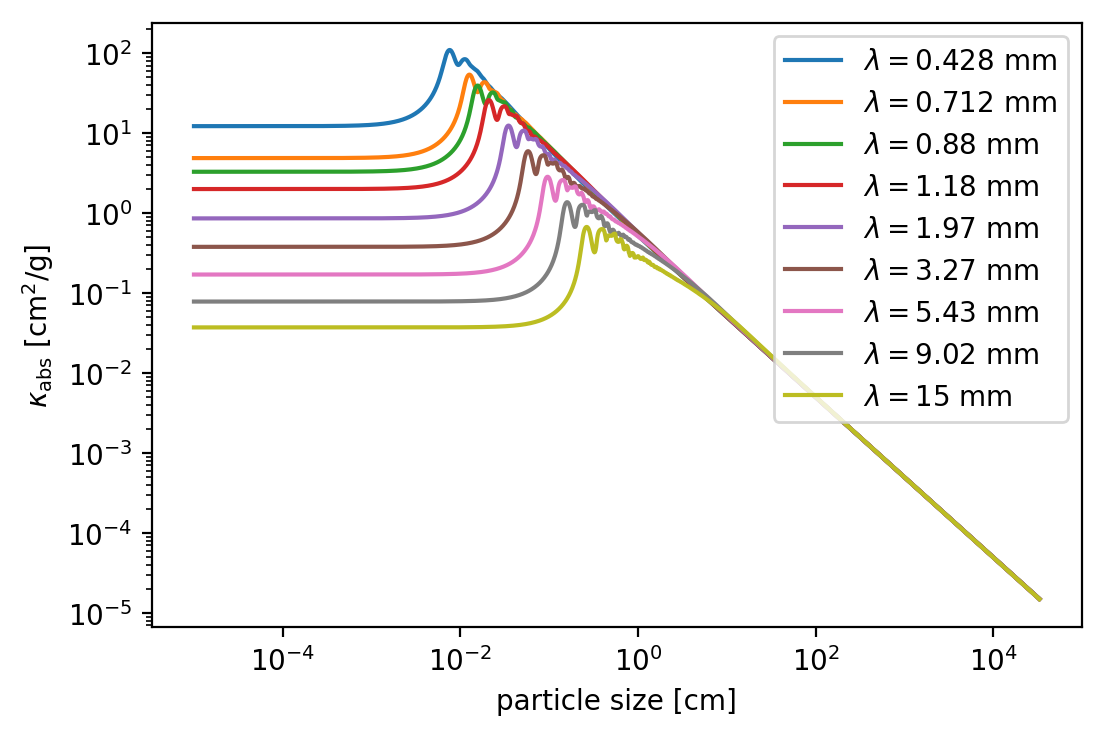

In [22]:
f, ax = plt.subplots()
for ilam in range(n_lam):
    ax.loglog(a_opac, k_a[:, ilam], label='$\lambda = {:.3g}$ mm'.format(10 * lam[ilam]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

## Calculate optical depth and emission profiles

Define the function that reconstructs the size distribution

In [3]:
a = np.logspace(np.log10(a_0), np.log10(5 * a_t.max()), 150) 

NameError: name 'a_0' is not defined

In [24]:
from twopoppy.distribution_reconstruction import reconstruct_size_distribution as rsd

In [30]:
def get_distri( it, r, a, time, sig_g, sig_d, alpha, rho_s, Temp, M_star, v_frag, a0=a_0):
    
    it =0
    if Temp.ndim == 1:
        T = Temp
    else:
        T = Temp[it]
    
    distri = rsd(
        r, 
        a, 
        time[it],
        sig_g[it],
        sig_d[it], 
        alpha, 
        rho_s, 
        T, 
        M_star, 
        v_frag,
        a_0 = 1e-5) 
    return distri[:2]



Define the function that will do all the work for us:

- interpolate the opacity on the particle size grid provided by the simulation itself
- calculate the size distribution and from that
- calculate optical depth, intensity profiles and from those
- r_eff and fluxes

In [31]:
def get_results(r, t, a, Temp, sample_time, it, lam, a_opac, k_a, distance=140 * pc, flux_fraction=0.68):
    """
    Calculates the radial profiles of the (vertical) optical depth and the intensity for a given simulation
    at a given time (using the closest simulation snapshot).
    
    Arguments:
    ----------
    
    res : twopoppy.results.results
        twopoppy simulation results object
        
    time : float
        time at which to calculate the results [s]
        
    lam : array
        wavelengths at which to calculate the results [cm]
        
    a_opac : array
        particle size grid on which the opacities are defined [cm]
        
    k_a : array
        absorption opacity as function of wavelength (grid lam) and
        particle size (grid a_opac) [cm^2/g]
        
    Keywords:
    ---------
    
    distance : float
        distance to source [cm]
        
    flux_fraction : float
        at which fraction of the total flux the effective radius is defined [-]
        
    Output:
    -------
    
    rf : array
        effective radii for every wavelength [cm]
    
    flux_t : array
        integrated flux for every wavelength [Jy]
        
    tau,Inu : array
        optical depth and intensity profiles at every wavelength [-, Jy/arcsec**2]
        
    sig_da, : array
        reconstructed particle size distribution on grid (res.a, res.x)
        
    a_max : array
        maximum particle size [cm]
    """

    # interpolate opacity on the same particle size grid as the size distribution
   
    kappa = np.array([10.**np.interp(np.log10(a), np.log10(a_opac), np.log10(k)) for k in k_a.T]).T  #interpolates the opacity
    
    it = np.abs(t - sample_time).argmin()
    
    if Temp.ndim == 1:
        T = Temp
    else:
        T = Temp[it]
        
    # reconstruct the size distribution
        
    sig_da, a_max = get_distri(2, r, a, time, sig_g, sig_d, alpha, rho_s, T, M_star, v_frag,a_0)
    
    # calculate planck function at every wavelength and radius

    Bnu = planck_B_nu(c_light / (np.array(lam, ndmin=2).T), np.array(T, ndmin=2))  # shape = (n_lam, n_r)

    # calculate optical depth

    tau = (kappa.T[:, :, np.newaxis] * sig_da[np.newaxis, :, :])  # shape = (n_l, n_a, n_r)
    tau = tau.sum(1)  # shape = (n_l, n_r)

    # calculate intensity at every wavelength and radius for this snapshot
    # here the intensity is still in plain CGS units (per sterad)

    intens = Bnu * (1 - np.exp(-tau))

    # calculate the fluxes
    
    flux = distance**-2 * cumtrapz(2 * np.pi * r * intens, x=r, axis=1, initial=0)
    
    flux_t = flux[:, -1] / 1e-23  # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

    # converted intensity to Jy/arcsec**2

    Inu = intens * arcsec_sq / 1e-23
    
#   interpolate radius whithin which >=68% of the dust mass is  # Effective radius (see Tripani)
#   rf = np.array([np.interp(flux_fraction, _f / _f[-1], res.x) for _f in flux])
    
    rf = np.array([np.interp(flux_fraction, _f / _f[-1], r) for _f in flux])
    
    path = '/home/apo/Codes/two-pop-py/results.csv'
    
    import pandas as pd
    
    data_dict = {'mdisk': [M_disk/M_sun], 'alpha' : [alpha[0]], 'r_c [AU]' : [r_c/au], 'v_frag' : [v_frag], 'reff [AU]' : [rf/au], 'fluxmm' : [flux_t]}
    df = pd.DataFrame(data=data_dict)
    column_order = [ 'mdisk', 'alpha', 'r_c [AU]', 'v_frag', 'reff [AU]', 'fluxmm']
    df = df[column_order]

    #df = df.append(data_dict, ignore_index=True)
    with open('/home/apo/Codes/two-pop-py/results.csv', 'a') as f:
        df.to_csv(f, header=False)
     
    return rf, flux_t, tau, Inu, sig_da, a_max

Now we call the function, passing our selected simulation, the time at which we want the results, and size/wavelength/opacity grids

In [3]:
for ALPHA in [0.01, 0.005, 0.001, 0.0001]:
    for MD in [0.005, 0.025, 0.05, 0.1]:
        for rc in [20, 80, 140, 200]:
            for v_frag in [1000, 3000, 6000, 10000]:             
                
                r_c    = rc*au        # disk characteristic radius [cm]
                rho_s  = 1.2          # material density of in Drazkowska
                M_star = M_sun        # stellar mass [g]
                M_disk = MD*M_star  # gas disk mass [g]
                d2g    = 0.01         # dust-to-gas ratio [-]
                a_0    = 1e-5         # initial particle size [cm]
# snapshot time [s]

                time  = np.logspace(2,6,n_t)*year

# initial conditions: gas and dust surface densities [g cm^-2]

                sig_g = (r/r_c)**-1*np.exp(-(r/r_c))
                sig_g = sig_g/np.trapz(2*np.pi*r*sig_g,x=r)*M_disk
                sig_d = d2g*sig_g

# power-law temperature [K]

                Temp     = 200.*(r/au)**-0.5

# alpha profile: a dip at 30*au - no scientific reason
                alpha = ALPHA*np.ones_like(r)
#alpha = 1e-2*np.ones_like(r)-9e-3*np.exp(-(r-30*au)**2/(2*(5*au)**2))

# v_gas is only for non-evolving gas disks, where you still
# want the dust to feel a gas velocity (e.g. a steady-state disk)
                v_gas = np.zeros_like(r)

                estick = 1.0
                opacity = np.load('opacity.npz') # load an npz file (array)
                k_a = opacity['k_a'] #len(k_a) = 1500
                k_s = opacity['k_s'] #len(k_s) = 1500
                lam = opacity['lam']  #all the three are contained in opacity.npz
                a_opac = opacity['a'] #len(a_opac) = 1500
                n_lam = len(lam)
                
                res = model.run(r, a_0, time, sig_g, sig_d, v_gas, Temp, alpha, M_star, v_frag, rho_s, 1)

                t     = res[0]
                sig_d = res[1]
                sig_g = res[2]
                v_bar = res[3]
                v_gas = res[4]
                v_0   = res[5]
                v_1   = res[6]
                a_dr  = res[7]
                a_fr  = res[8]
                a_df  = res[9]
                a_t   = res[10]
                
                a = np.logspace(np.log10(a_0), np.log10(5 * a_t.max()), 150) 
                from twopoppy.distribution_reconstruction import reconstruct_size_distribution as rsd
                def get_distri( it, r, a, time, sig_g, sig_d, alpha, rho_s, Temp, M_star, v_frag, a0=a_0):
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
    
                    distri = rsd(
                        r, 
                        a, 
                        time[it],
                        sig_g[it],
                        sig_d[it], 
                        alpha, 
                        rho_s, 
                        T, 
                        M_star, 
                        v_frag,
                        a_0 = 1e-5) 
                    return distri[:2]

        
                def get_results(r, t, a, Temp, sample_time, it, lam, a_opac, k_a, distance=140 * pc, flux_fraction=0.68):
    

    # interpolate opacity on the same particle size grid as the size distribution
   
                    kappa = np.array([10.**np.interp(np.log10(a), np.log10(a_opac), np.log10(k)) for k in k_a.T]).T  #interpolates the opacity
    
                    it = np.abs(t - sample_time).argmin()
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
        
    # reconstruct the size distribution
        
                    sig_da, a_max = get_distri(2, r, a, time, sig_g, sig_d, alpha, rho_s, T, M_star, v_frag,a_0)
    
    # calculate planck function at every wavelength and radius

                    Bnu = planck_B_nu(c_light / (np.array(lam, ndmin=2).T), np.array(T, ndmin=2))  # shape = (n_lam, n_r)

    # calculate optical depth

                    tau = (kappa.T[:, :, np.newaxis] * sig_da[np.newaxis, :, :])  # shape = (n_l, n_a, n_r)
                    tau = tau.sum(1)  # shape = (n_l, n_r)

    # calculate intensity at every wavelength and radius for this snapshot
    # here the intensity is still in plain CGS units (per sterad)

                    intens = Bnu * (1 - np.exp(-tau))

    # calculate the fluxes
    
                    flux = distance**-2 * cumtrapz(2 * np.pi * r * intens, x=r, axis=1, initial=0)
    
                    flux_t = flux[:, -1] / 1e-23  # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

    # converted intensity to Jy/arcsec**2

                    Inu = intens * arcsec_sq / 1e-23
    
#   interpolate radius whithin which >=68% of the dust mass is  # Effective radius (see Tripani)
#   rf = np.array([np.interp(flux_fraction, _f / _f[-1], res.x) for _f in flux])
    
                    rf = np.array([np.interp(flux_fraction, _f / _f[-1], r) for _f in flux])
    
                    path = '/home/apo/Codes/two-pop-py/results.csv'
    
                    import pandas as pd
        
                    data_dict = {'mdisk': [M_disk/M_sun], 'alpha' : [alpha[0]], 'r_c [AU]' : [r_c/au], 'v_frag' : [v_frag], 'reff [AU]' : [rf/au], 'fluxmm' : [flux_t]}
                    df = pd.DataFrame(data=data_dict)
                    column_order = [ 'mdisk', 'alpha', 'r_c [AU]', 'v_frag', 'reff [AU]', 'fluxmm']
                    df = df[column_order]

    #df = df.append(data_dict, ignore_index=True)
                    with open('/home/apo/Codes/two-pop-py/results.csv', 'a') as f:
                        df.to_csv(f, header=False)
     
                    return rf, flux_t, tau, Inu, sig_da, a_max
        

                
                sample_time = t.searchsorted(1e6 * year)  #check searchsorted
                IT  = [-1]
                rf, flux_t, tau, Inu, sig_da, a_max = get_results(r, t, a, Temp, sample_time, IT, lam, a_opac, k_a)
                

toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


In [34]:
sample_time = t.searchsorted(1e6 * year)  #check searchsorted
#it = np.abs(t - sample_time).argmin()
IT  = [-1]
rf, flux_t, tau, Inu, sig_da, a_max = get_results(r, t, a, Temp, sample_time, IT, lam, a_opac, k_a)

/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))


Plot the reconstructed size distribution

In [ ]:
df = pd.read_csv('/home/apo/Codes/two-pop-py/results.csv')
df

In [35]:
print(flux_t)

[  1.35495248e+00   3.31908708e-01   1.71508069e-01   6.73708287e-02
   1.23299100e-02   2.13628893e-03   3.63266812e-04   6.17103009e-05
   1.07360949e-05]


In [ ]:
#it = np.abs(t - sample_time).argmin()
f, ax = plt.subplots()
ymax = np.ceil(np.log10(sig_da.max()))
for it in IT:
    cc = ax.contourf(r / au, a, np.log10(sig_da), np.arange(ymax - 10, ymax + 1))
    ax.loglog(r / au, a_fr[it], label='a_fr, t = {:.3g} yr'.format(t[it]/year))
    ax.loglog(r / au, a_dr[it], '--', label='a_dr, t = {:.3g} yr'.format(t[it]/year))
ax.legend()
ax.set_ylim(ymin=a[0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('particle size [cm]')
cb = plt.colorbar(cc)
cb.set_label('$\log_{10}\,\Sigma_\mathrm{dust}$ [g cm$^{-2}$]');

## Plot the emission profiles

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(6, 8))

for i_lam in range(len(lam)):

    l, = ax[0].loglog(r / au, Inu[i_lam])

    cum = cumtrapz(2 * np.pi * r * Inu[i_lam], x=r, initial=1e-10)
    cum = cum / cum[-1]
    ax[1].semilogx(r / au, cum, color=l.get_color(), label='{:.3g} cm'.format(lam[i_lam]))

ax[1].axhline(0.68, c='k', ls='--', label='0.68') 
    
ax[0].set_ylim(1e-10, 1e2)
ax[1].set_ylim(0.1, 0.9)
ax[1].set_xlim(1e-1, 3e2)
ax[1].legend();

## Plot the spectral dependence of $r_\mathrm{eff}$ and the flux

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(6, 10))
ax[0].semilogx(c_light / lam / 1e9, rf / au)
ax[0].set_ylim(0, 100)
ax[0].set_xlim(10, 1000)
ax[0].set_xlabel(r'$\nu$ [GHz]')
ax[0].set_ylabel(r'$R_\mathrm{eff}$ [au]')
ax[1].loglog(c_light / lam / 1e9, flux_t * 1e3)
ax[1].set_ylim(4e-2, 9e2)
ax[1].set_xlim(10, 9e2)
ax[1].set_xlabel(r'$\nu$ [GHz]')
ax[1].set_ylabel(r'$F_\nu$ [mJy]')

ax[0].set_title('(Md,Rc,alpha,vfrag) = {:.4g}M*, {:.4g}AU, {:.4g} , {:.4g}cm/s'.format(M_disk / M_star, r_c / au, alpha[0], v_frag ))
f.savefig('fig1.pdf')

In [ ]:
print(rf)